# Importing Packages

In [1]:
# Importing necessary packages

import yfinance as yf
import pandas as pd
import numpy as np
import wbdata
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import datetime

# For the web scrape
import requests
from bs4 import BeautifulSoup


In [2]:
start_date = '1985-01-01'
end_date = '2024-01-01'
initial_investment = 50000
monthly_investment = 2000

# Data Preperation

### S&P500

In [3]:
# Get historical data for the S&P 500 (^GSPC)
stock = yf.Ticker("^GSPC")
df = stock.history(period="max")

# Keep the first values from the first day of the month
df = df.resample('ME').first()

# Reset the index to move the date from the index to a column
df.reset_index(inplace=True)

# Ensure the 'Date' column is a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Keep 2 columns, and only look at dates between 1985 and 2024
df = df[['Date','Open']]
df = df[df['Date'] >= start_date]
df = df[df['Date'] < end_date]

# Create a new column that is a concatenation of the year and month
# This column will be used in later steps as the unique identifier when joining CPI data
df['Year_Month'] = df['Date'].dt.strftime('%Y-%m')
df = df.rename(columns={'Date': 'date', 'Open': 'open', 'Year_Month': 'year_month'})

display(df)

,date,open,year_month
685,1985-01-31 00:00:00-05:00,167.199997,1985-01
686,1985-02-28 00:00:00-05:00,179.630005,1985-02
687,1985-03-31 00:00:00-05:00,181.179993,1985-03
688,1985-04-30 00:00:00-04:00,180.660004,1985-04
689,1985-05-31 00:00:00-04:00,179.830002,1985-05
...,...,...,...
1148,2023-08-31 00:00:00-04:00,4578.830078,2023-08
1149,2023-09-30 00:00:00-04:00,4530.600098,2023-09
1150,2023-10-31 00:00:00-04:00,4284.520020,2023-10
1151,2023-11-30 00:00:00-05:00,4201.270020,2023-11


### CPI Data

In [4]:
# Load CPI data from CSV (adjust path and file name)
cpi_data = pd.read_csv('cpi_monthly_USA.csv')
cpi_data['DATE'] = pd.to_datetime(cpi_data['DATE'])
cpi_data['YEAR_MONTH'] = cpi_data['DATE'].dt.strftime('%Y-%m')
cpi_data = cpi_data.rename(columns={'DATE': 'date', 'CPIAUCSL': 'cpi', 'YEAR_MONTH': 'year_month'})

display(cpi_data)

,date,cpi,year_month
0,1947-01-01,21.480,1947-01
1,1947-02-01,21.620,1947-02
2,1947-03-01,22.000,1947-03
3,1947-04-01,22.000,1947-04
4,1947-05-01,21.950,1947-05
...,...,...,...
924,2024-01-01,309.685,2024-01
925,2024-02-01,311.054,2024-02
926,2024-03-01,312.230,2024-03
927,2024-04-01,313.207,2024-04


### Dividend Data

In [5]:

url = 'https://www.multpl.com/s-p-500-dividend-yield/table/by-month'
response = requests.get(url)
response.raise_for_status()  # Check if the request was successful

# Step 2: Parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')

# Step 3: Find the table (adjust the selector as needed)
table = soup.find('table')

# Step 4: Extract the table headers
headers = []
for th in table.find_all('th'):
    headers.append(th.get_text(strip=True))

# Step 5: Extract the table rows
rows = []
for tr in table.find_all('tr'):
    cells = tr.find_all(['td', 'th'])
    if len(cells) > 0:
        row = [cell.get_text(strip=True) for cell in cells]
        rows.append(row)

# Step 6: Create a DataFrame
df_dividends = pd.DataFrame(rows[1:], columns=rows[0])

# Convert 'Date' column to datetime
df_dividends['Date'] = pd.to_datetime(df_dividends['Date'], format='%b %d, %Y')
df_dividends['Year'] = df_dividends['Date'].dt.year

# Keep dates up until 2024
df_dividends = df_dividends[df_dividends['Date'] < '2024-01-01']
df_dividends = df_dividends[df_dividends['Date'] > '1985-01-01']

df_dividends['Value'] = df_dividends['Value'].str.replace('%','')

# # Convert 'Value' columns to float
df_dividends['Value'] = pd.to_numeric(df_dividends['Value'])/100

# Let's get to the yearly level
df_dividends = df_dividends.groupby('Year')['Value'].mean().reset_index()

# Let's rename stuff
df_dividends = df_dividends.rename(columns={'Year': 'year', 'Value': 'dividend'})

display(df_dividends)

,year,dividend
0,1985,0.041575
1,1986,0.034433
2,1987,0.030042
3,1988,0.034883
4,1989,0.032408
5,1990,0.034900
6,1991,0.032433
7,1992,0.029683
8,1993,0.027717
9,1994,0.027950


### Merge

In [6]:
# We merge the cpi and the s&p data together
merged_df = pd.merge(df, cpi_data[['year_month', 'cpi']], left_on = 'year_month', right_on = 'year_month', how='left')
merged_df['year'] = merged_df['date'].dt.year
merged_df = pd.merge(merged_df, df_dividends[['year', 'dividend']], left_on = 'year', right_on = 'year', how = 'left')
merged_df['dividend'] = np.where(merged_df['date'].dt.month == 1, merged_df['dividend'], 0)
# We create 3 new columns which represent:

# (1) The monthly return as a percentage
merged_df['nominal_return'] = (merged_df['open']-merged_df['open'].shift(1))/merged_df['open'].shift(1)
# (2) The monthly inflation rate
merged_df['inflation_rate'] = (merged_df['cpi']-merged_df['cpi'].shift(1))/merged_df['cpi'].shift(1)
# (3) Given that we know 1 and 2, we can calculate the 'real' return rate
merged_df['real_return'] = (1+merged_df['nominal_return'])/(1+merged_df['inflation_rate'])-1

# Reordering the columns
merged_df = merged_df[['date', 'year_month', 'open', 'nominal_return', 'cpi', 'inflation_rate', 'real_return', 'dividend']]
display(merged_df)

,date,year_month,open,nominal_return,cpi,inflation_rate,real_return,dividend
0,1985-01-31 00:00:00-05:00,1985-01,167.199997,NaN,105.700,NaN,NaN,0.041575
1,1985-02-28 00:00:00-05:00,1985-02,179.630005,0.074342,106.300,0.005676,0.068278,0.000000
2,1985-03-31 00:00:00-05:00,1985-03,181.179993,0.008629,106.800,0.004704,0.003907,0.000000
3,1985-04-30 00:00:00-04:00,1985-04,180.660004,-0.002870,107.000,0.001873,-0.004734,0.000000
4,1985-05-31 00:00:00-04:00,1985-05,179.830002,-0.004594,107.200,0.001869,-0.006451,0.000000
...,...,...,...,...,...,...,...,...
463,2023-08-31 00:00:00-04:00,2023-08,4578.830078,0.028840,306.187,0.005118,0.023601,0.000000
464,2023-09-30 00:00:00-04:00,2023-09,4530.600098,-0.010533,307.288,0.003596,-0.014078,0.000000
465,2023-10-31 00:00:00-04:00,2023-10,4284.520020,-0.054315,307.531,0.000791,-0.055062,0.000000
466,2023-11-30 00:00:00-05:00,2023-11,4201.270020,-0.019430,308.024,0.001603,-0.021000,0.000000


### Investing Options

In [7]:
# Initialize the first row of the new column
merged_df.at[0,'nominal'] = initial_investment
merged_df.at[0,'real'] = initial_investment
merged_df.at[0,'nominal_no_dividend'] = initial_investment
merged_df.at[0,'real_no_dividend'] = initial_investment
merged_df.at[0,'nominal_no_increase'] = initial_investment
merged_df.at[0,'real_no_increase'] = initial_investment
merged_df.at[0,'hypothetical_7'] = initial_investment
merged_df.at[0,'hypothetical_10'] = initial_investment


# We create 8 columns
# (1) Nominal net worth after increasing investments by inflation and reinvesting dividends
# (2) Same as (1) but in real terms
# (3) Same as (1) but no dividends
# (4) Same as (3) but in real terms
# (5) Same as (1) but no increasing monthly savings
# (6) Same as (5) but in real terms
# (7) Assuming consistent 7% yearly increase in your money
# (8) Assuming consistent 10% yearly increase in your money

for i in range(1, len(merged_df)):
    merged_df.at[i,'nominal']             = merged_df.at[i-1,'nominal']*(1+merged_df.at[i,'nominal_return']) + monthly_investment*merged_df.at[i,'cpi']/merged_df.at[0,'cpi'] + merged_df.at[i-1,'nominal']*merged_df.at[i,'dividend']
    merged_df.at[i,'real']                = merged_df.at[i-1,'real']*(1+merged_df.at[i,'real_return']) + monthly_investment*merged_df.at[i,'cpi']/merged_df.at[0,'cpi'] + merged_df.at[i-1,'real']*merged_df.at[i,'dividend']
    merged_df.at[i,'nominal_no_dividend'] = merged_df.at[i-1,'nominal_no_dividend']*(1+merged_df.at[i,'nominal_return']) + monthly_investment*merged_df.at[i,'cpi']/merged_df.at[0,'cpi']
    merged_df.at[i,'real_no_dividend']    = merged_df.at[i-1,'real_no_dividend']*(1+merged_df.at[i,'real_return']) + monthly_investment*merged_df.at[i,'cpi']/merged_df.at[0,'cpi']
    merged_df.at[i,'nominal_no_increase'] = merged_df.at[i-1,'nominal_no_increase']*(1+merged_df.at[i,'nominal_return']) + monthly_investment + merged_df.at[i-1,'nominal_no_increase']*merged_df.at[i,'dividend']
    merged_df.at[i,'real_no_increase']    = merged_df.at[i-1,'real_no_increase']*(1+merged_df.at[i,'real_return']) + monthly_investment + merged_df.at[i-1,'real_no_increase']*merged_df.at[i,'dividend']
    merged_df.at[i,'hypothetical_7']      = merged_df.at[i-1,'hypothetical_7']*(1.00643) + monthly_investment*merged_df.at[i,'cpi']/merged_df.at[0,'cpi']
    merged_df.at[i,'hypothetical_10']     = merged_df.at[i-1,'hypothetical_10']*(1.00797) + monthly_investment*merged_df.at[i,'cpi']/merged_df.at[0,'cpi']

display(merged_df)


,date,year_month,open,nominal_return,cpi,inflation_rate,real_return,dividend,nominal,real,nominal_no_dividend,real_no_dividend,nominal_no_increase,real_no_increase,hypothetical_7,hypothetical_10
0,1985-01-31 00:00:00-05:00,1985-01,167.199997,NaN,105.700,NaN,NaN,0.041575,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04
1,1985-02-28 00:00:00-05:00,1985-02,179.630005,0.074342,106.300,0.005676,0.068278,0.000000,5.572846e+04,5.542526e+04,5.572846e+04,5.542526e+04,5.571711e+04,5.541391e+04,5.233285e+04,5.240985e+04
2,1985-03-31 00:00:00-05:00,1985-03,181.179993,0.008629,106.800,0.004704,0.003907,0.000000,5.823014e+04,5.766261e+04,5.823014e+04,5.766261e+04,5.819788e+04,5.763039e+04,5.469017e+04,5.484837e+04
3,1985-04-30 00:00:00-04:00,1985-04,180.660004,-0.002870,107.000,0.001873,-0.004734,0.000000,6.008762e+04,5.941424e+04,6.008762e+04,5.941424e+04,6.003085e+04,5.935758e+04,5.706642e+04,5.731011e+04
4,1985-05-31 00:00:00-04:00,1985-05,179.830002,-0.004594,107.200,0.001869,-0.006451,0.000000,6.183994e+04,6.105932e+04,6.183994e+04,6.105932e+04,6.175505e+04,6.097464e+04,5.946174e+04,5.979526e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2023-08-31 00:00:00-04:00,2023-08,4578.830078,0.028840,306.187,0.005118,0.023601,0.000000,1.716450e+07,8.254416e+06,9.919793e+06,5.104403e+06,1.332599e+07,5.934099e+06,9.311550e+06,1.542358e+07
464,2023-09-30 00:00:00-04:00,2023-09,4530.600098,-0.010533,307.288,0.003596,-0.014078,0.000000,1.698952e+07,8.144021e+06,9.821120e+06,5.038355e+06,1.318762e+07,5.852556e+06,9.377238e+06,1.555232e+07
465,2023-10-31 00:00:00-04:00,2023-10,4284.520020,-0.054315,307.531,0.000791,-0.055062,0.000000,1.607255e+07,7.701411e+06,9.293503e+06,4.766750e+06,1.247333e+07,5.532301e+06,9.443352e+06,1.568209e+07
466,2023-11-30 00:00:00-05:00,2023-11,4201.270020,-0.019430,308.024,0.001603,-0.021000,0.000000,1.576608e+07,7.545511e+06,9.118755e+06,4.672477e+06,1.223297e+07,5.418123e+06,9.509901e+06,1.581290e+07


# Analysis

### Visualizations

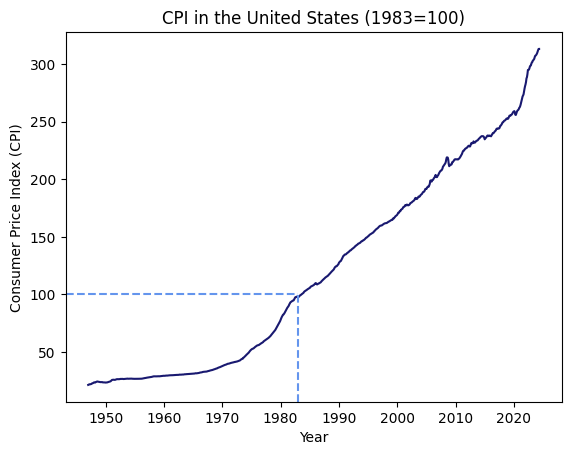

In [9]:
meeting_year = datetime.datetime(1983,1,1)
meeting_CPI = 100

plt.plot(cpi_data['date'], cpi_data['cpi'], color = 'midnightblue')
plt.title('CPI in the United States (1983=100)')
plt.xlabel('Year')
plt.ylabel('Consumer Price Index (CPI)')
plt.axhline(y=meeting_CPI, color='cornflowerblue', linestyle='--', xmax=0.469)
plt.axvline(x=meeting_year, color='cornflowerblue', linestyle='--', ymax=0.29)


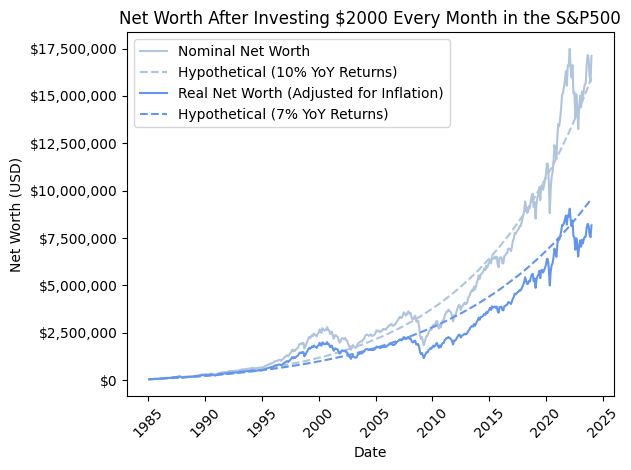

In [8]:
# Create figure and axis objects
fig, ax = plt.subplots()

# Plot 'open' and 'open_real' against 'date'
ax.plot(merged_df['date'], merged_df['nominal'], color='lightsteelblue',label='Nominal Net Worth')
ax.plot(merged_df['date'], merged_df['hypothetical_10'], color = 'lightsteelblue', linestyle='dashed', label='Hypothetical (10% YoY Returns)')
ax.plot(merged_df['date'], merged_df['real'], color='cornflowerblue', label='Real Net Worth (Adjusted for Inflation)')
ax.plot(merged_df['date'], merged_df['hypothetical_7'], color = 'cornflowerblue', linestyle='dashed', label='Hypothetical (7% YoY Returns)')
# ax.plot(merged_df['date'], merged_df['real_money_3'], color='midnightblue', label='Real Net Worth + Dividends')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Net Worth (USD)')
ax.set_title(f'Net Worth After Investing ${monthly_investment} Every Month in the S&P500')

# Display legends
ax.legend()

# Function to format the y-axis labels with commas
def y_axis_format(x, pos):
    return f'${int(x):,}'

ax.yaxis.set_major_formatter(FuncFormatter(y_axis_format))

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

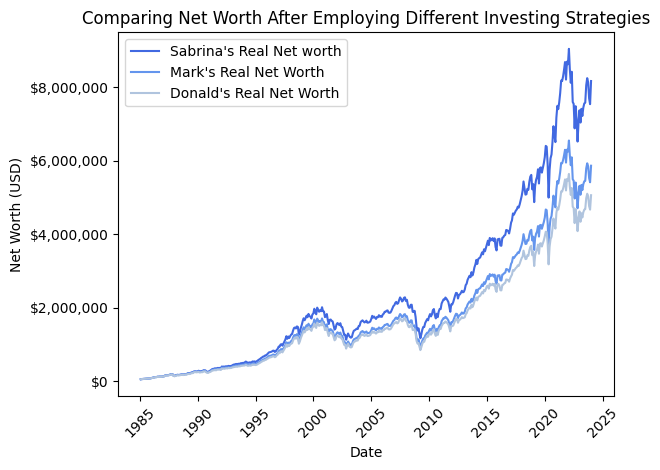

In [10]:
# Create figure and axis objects
fig, ax = plt.subplots()

# Plot 'open' and 'open_real' against 'date'
ax.plot(merged_df['date'], merged_df['real'], color='royalblue',label='Sabrina\'s Real Net worth')
ax.plot(merged_df['date'], merged_df['real_no_increase'], color = 'cornflowerblue', label='Mark\'s Real Net Worth')
ax.plot(merged_df['date'], merged_df['real_no_dividend'], color = 'lightsteelblue', label='Donald\'s Real Net Worth')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Net Worth (USD)')
ax.set_title(f'Comparing Net Worth After Employing Different Investing Strategies')
# Display legends
ax.legend()

# Function to format the y-axis labels with commas
def y_axis_format(x, pos):
    return f'${int(x):,}'

ax.yaxis.set_major_formatter(FuncFormatter(y_axis_format))

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()